# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

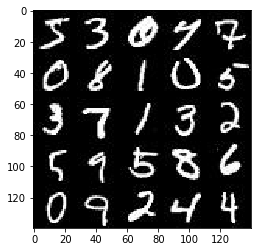

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

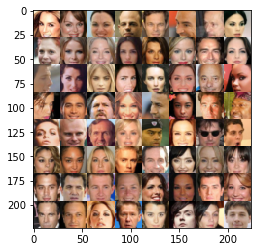

In [3]:
show_n_images = 64

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, [], name='learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    # using similar code from DCGAN assignment, added alpha
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 256, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 512, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256
        
        #x4 = tf.layers.conv2d(relu3, 512, 5, strides=2, padding='same')
        #bn4 = tf.layers.batch_normalization(x4, training=True)
        #relu4 = tf.maximum(alpha * bn4, bn4)
        # 2x2x512

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*512))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    # using similar code from DCGAN assignment, added alpha
    reuse = not is_train
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 28x28x128 now
        
        # Output layer
        # strides to 1 based on feedback
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    # using similar code from DCGAN assignment
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # using similar code from DCGAN assignment
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    #print(data_shape)
    #tf.reset_default_graph()
    input_real, input_z, _ = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    
    steps = 0
    print_every = 50
    show_every = 500

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images*2, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images*2})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images*2})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 16, input_z, data_shape[3], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.0191... Generator Loss: 5.8969
Epoch 1/2... Discriminator Loss: 2.0657... Generator Loss: 0.2486
Epoch 1/2... Discriminator Loss: 1.4829... Generator Loss: 0.3555
Epoch 1/2... Discriminator Loss: 0.8896... Generator Loss: 1.2371
Epoch 1/2... Discriminator Loss: 0.7610... Generator Loss: 2.1965
Epoch 1/2... Discriminator Loss: 1.0949... Generator Loss: 0.8456
Epoch 1/2... Discriminator Loss: 1.5920... Generator Loss: 0.4653
Epoch 1/2... Discriminator Loss: 1.8176... Generator Loss: 0.2426
Epoch 1/2... Discriminator Loss: 0.9647... Generator Loss: 0.8935
Epoch 1/2... Discriminator Loss: 1.4672... Generator Loss: 0.3968


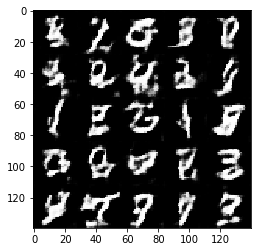

Epoch 1/2... Discriminator Loss: 1.1814... Generator Loss: 0.5162
Epoch 1/2... Discriminator Loss: 1.0195... Generator Loss: 0.5914
Epoch 1/2... Discriminator Loss: 1.3053... Generator Loss: 0.4030
Epoch 1/2... Discriminator Loss: 0.7103... Generator Loss: 0.9270
Epoch 1/2... Discriminator Loss: 1.0769... Generator Loss: 4.4832
Epoch 1/2... Discriminator Loss: 2.3349... Generator Loss: 0.1198
Epoch 1/2... Discriminator Loss: 1.3118... Generator Loss: 0.7314
Epoch 1/2... Discriminator Loss: 0.4301... Generator Loss: 1.5090
Epoch 1/2... Discriminator Loss: 1.0154... Generator Loss: 1.0802
Epoch 1/2... Discriminator Loss: 1.1388... Generator Loss: 0.5020


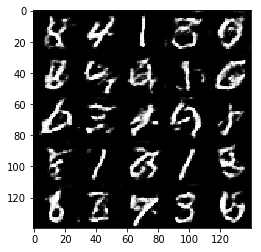

Epoch 1/2... Discriminator Loss: 0.6873... Generator Loss: 0.9168
Epoch 1/2... Discriminator Loss: 2.0714... Generator Loss: 0.1946
Epoch 1/2... Discriminator Loss: 0.8577... Generator Loss: 0.7235
Epoch 1/2... Discriminator Loss: 0.8644... Generator Loss: 0.6672
Epoch 1/2... Discriminator Loss: 0.8617... Generator Loss: 1.2316
Epoch 1/2... Discriminator Loss: 1.1332... Generator Loss: 0.5209
Epoch 1/2... Discriminator Loss: 2.3225... Generator Loss: 0.1542
Epoch 1/2... Discriminator Loss: 2.4056... Generator Loss: 0.1400
Epoch 1/2... Discriminator Loss: 1.6906... Generator Loss: 0.3124
Epoch 1/2... Discriminator Loss: 0.7988... Generator Loss: 0.7629


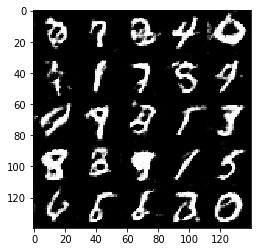

Epoch 1/2... Discriminator Loss: 0.7451... Generator Loss: 0.8110
Epoch 1/2... Discriminator Loss: 3.0957... Generator Loss: 0.2095
Epoch 1/2... Discriminator Loss: 0.3464... Generator Loss: 1.5735
Epoch 1/2... Discriminator Loss: 0.8706... Generator Loss: 0.8017
Epoch 1/2... Discriminator Loss: 0.5540... Generator Loss: 1.3855
Epoch 1/2... Discriminator Loss: 1.5203... Generator Loss: 0.2897
Epoch 1/2... Discriminator Loss: 1.0674... Generator Loss: 0.5404
Epoch 2/2... Discriminator Loss: 0.5913... Generator Loss: 1.0367
Epoch 2/2... Discriminator Loss: 0.3869... Generator Loss: 1.5984
Epoch 2/2... Discriminator Loss: 0.9032... Generator Loss: 1.5626


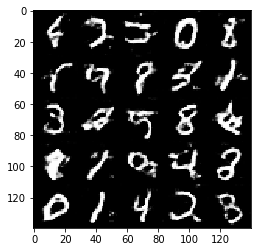

Epoch 2/2... Discriminator Loss: 1.2240... Generator Loss: 0.4932
Epoch 2/2... Discriminator Loss: 1.1092... Generator Loss: 0.5189
Epoch 2/2... Discriminator Loss: 4.0206... Generator Loss: 0.0322
Epoch 2/2... Discriminator Loss: 1.0796... Generator Loss: 0.5389
Epoch 2/2... Discriminator Loss: 2.0759... Generator Loss: 0.1719
Epoch 2/2... Discriminator Loss: 0.9759... Generator Loss: 0.5975
Epoch 2/2... Discriminator Loss: 0.4508... Generator Loss: 1.7427
Epoch 2/2... Discriminator Loss: 0.3359... Generator Loss: 1.6556
Epoch 2/2... Discriminator Loss: 0.4491... Generator Loss: 2.2886
Epoch 2/2... Discriminator Loss: 2.5194... Generator Loss: 4.4408


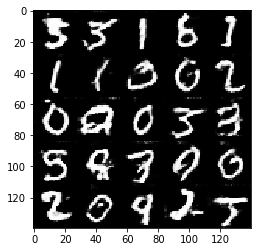

Epoch 2/2... Discriminator Loss: 0.8596... Generator Loss: 0.6890
Epoch 2/2... Discriminator Loss: 0.6522... Generator Loss: 0.9545
Epoch 2/2... Discriminator Loss: 2.0377... Generator Loss: 0.1865
Epoch 2/2... Discriminator Loss: 1.0402... Generator Loss: 0.5796
Epoch 2/2... Discriminator Loss: 1.2243... Generator Loss: 0.4632
Epoch 2/2... Discriminator Loss: 0.7821... Generator Loss: 3.1347
Epoch 2/2... Discriminator Loss: 1.4255... Generator Loss: 0.3546
Epoch 2/2... Discriminator Loss: 1.0163... Generator Loss: 0.7023
Epoch 2/2... Discriminator Loss: 0.5112... Generator Loss: 2.3749
Epoch 2/2... Discriminator Loss: 0.5549... Generator Loss: 1.4903


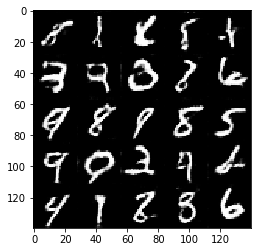

Epoch 2/2... Discriminator Loss: 0.5558... Generator Loss: 1.1543
Epoch 2/2... Discriminator Loss: 1.4341... Generator Loss: 2.3318
Epoch 2/2... Discriminator Loss: 0.4463... Generator Loss: 1.5165
Epoch 2/2... Discriminator Loss: 0.4554... Generator Loss: 1.3893
Epoch 2/2... Discriminator Loss: 0.2074... Generator Loss: 2.2032
Epoch 2/2... Discriminator Loss: 1.2010... Generator Loss: 0.6097
Epoch 2/2... Discriminator Loss: 2.1504... Generator Loss: 0.1868
Epoch 2/2... Discriminator Loss: 0.2658... Generator Loss: 1.7481
Epoch 2/2... Discriminator Loss: 1.9302... Generator Loss: 0.2142
Epoch 2/2... Discriminator Loss: 1.2511... Generator Loss: 0.4099


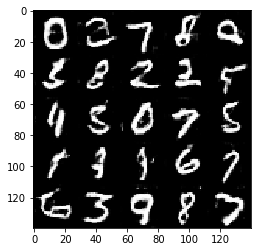

Epoch 2/2... Discriminator Loss: 1.1208... Generator Loss: 0.5501
Epoch 2/2... Discriminator Loss: 0.4917... Generator Loss: 2.1844
Epoch 2/2... Discriminator Loss: 1.3754... Generator Loss: 0.3473
Epoch 2/2... Discriminator Loss: 1.1074... Generator Loss: 0.5412
Epoch 2/2... Discriminator Loss: 0.9793... Generator Loss: 0.5882


In [15]:
batch_size = 32
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.5593... Generator Loss: 3.1064
Epoch 1/1... Discriminator Loss: 1.3786... Generator Loss: 0.6749
Epoch 1/1... Discriminator Loss: 0.7105... Generator Loss: 1.6306
Epoch 1/1... Discriminator Loss: 1.3997... Generator Loss: 0.6805
Epoch 1/1... Discriminator Loss: 1.5393... Generator Loss: 1.9052
Epoch 1/1... Discriminator Loss: 0.9283... Generator Loss: 2.1599
Epoch 1/1... Discriminator Loss: 1.1737... Generator Loss: 0.6831
Epoch 1/1... Discriminator Loss: 0.9347... Generator Loss: 0.9729
Epoch 1/1... Discriminator Loss: 1.1308... Generator Loss: 1.1569
Epoch 1/1... Discriminator Loss: 0.8870... Generator Loss: 2.3015


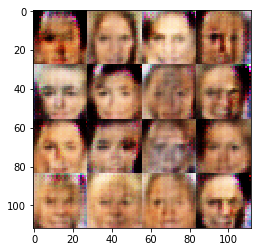

Epoch 1/1... Discriminator Loss: 0.7225... Generator Loss: 1.1766
Epoch 1/1... Discriminator Loss: 0.6007... Generator Loss: 1.7830
Epoch 1/1... Discriminator Loss: 0.8523... Generator Loss: 0.9983
Epoch 1/1... Discriminator Loss: 1.0048... Generator Loss: 0.6653
Epoch 1/1... Discriminator Loss: 1.5956... Generator Loss: 0.3153
Epoch 1/1... Discriminator Loss: 1.8089... Generator Loss: 0.2290
Epoch 1/1... Discriminator Loss: 1.0578... Generator Loss: 0.8606
Epoch 1/1... Discriminator Loss: 0.9027... Generator Loss: 1.1457
Epoch 1/1... Discriminator Loss: 1.2289... Generator Loss: 0.5098
Epoch 1/1... Discriminator Loss: 1.2213... Generator Loss: 1.0970


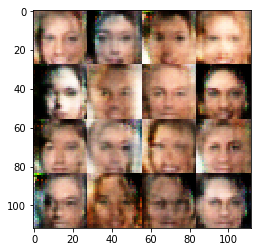

Epoch 1/1... Discriminator Loss: 0.9583... Generator Loss: 0.7254
Epoch 1/1... Discriminator Loss: 1.2123... Generator Loss: 0.5706
Epoch 1/1... Discriminator Loss: 0.8731... Generator Loss: 0.8626
Epoch 1/1... Discriminator Loss: 1.0281... Generator Loss: 0.6925
Epoch 1/1... Discriminator Loss: 1.0103... Generator Loss: 0.6586
Epoch 1/1... Discriminator Loss: 1.0746... Generator Loss: 0.8349
Epoch 1/1... Discriminator Loss: 1.0988... Generator Loss: 0.7087
Epoch 1/1... Discriminator Loss: 3.0067... Generator Loss: 3.5865
Epoch 1/1... Discriminator Loss: 1.2525... Generator Loss: 1.6664
Epoch 1/1... Discriminator Loss: 0.7740... Generator Loss: 1.1503


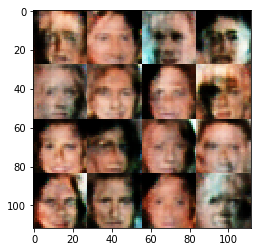

Epoch 1/1... Discriminator Loss: 1.0086... Generator Loss: 1.6232
Epoch 1/1... Discriminator Loss: 1.0321... Generator Loss: 1.1057
Epoch 1/1... Discriminator Loss: 1.1058... Generator Loss: 0.5878
Epoch 1/1... Discriminator Loss: 1.0741... Generator Loss: 0.8277
Epoch 1/1... Discriminator Loss: 1.1178... Generator Loss: 0.5590
Epoch 1/1... Discriminator Loss: 1.9201... Generator Loss: 0.2135
Epoch 1/1... Discriminator Loss: 1.0444... Generator Loss: 0.9051
Epoch 1/1... Discriminator Loss: 0.4505... Generator Loss: 1.9759
Epoch 1/1... Discriminator Loss: 1.1237... Generator Loss: 0.5950
Epoch 1/1... Discriminator Loss: 0.7398... Generator Loss: 1.8919


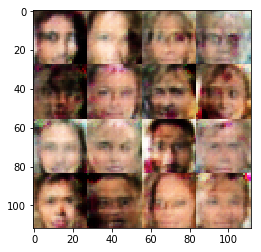

Epoch 1/1... Discriminator Loss: 0.8866... Generator Loss: 1.3946
Epoch 1/1... Discriminator Loss: 0.5729... Generator Loss: 1.2709
Epoch 1/1... Discriminator Loss: 1.4514... Generator Loss: 2.4255
Epoch 1/1... Discriminator Loss: 0.6587... Generator Loss: 1.5799
Epoch 1/1... Discriminator Loss: 1.1017... Generator Loss: 0.5978
Epoch 1/1... Discriminator Loss: 1.1200... Generator Loss: 0.7794
Epoch 1/1... Discriminator Loss: 1.0843... Generator Loss: 1.2593
Epoch 1/1... Discriminator Loss: 0.9707... Generator Loss: 0.6177
Epoch 1/1... Discriminator Loss: 1.3231... Generator Loss: 0.6679
Epoch 1/1... Discriminator Loss: 1.3576... Generator Loss: 2.0279


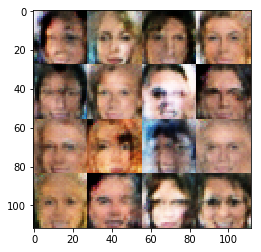

Epoch 1/1... Discriminator Loss: 1.7037... Generator Loss: 1.7731
Epoch 1/1... Discriminator Loss: 0.9603... Generator Loss: 0.7634
Epoch 1/1... Discriminator Loss: 1.4688... Generator Loss: 0.3370
Epoch 1/1... Discriminator Loss: 1.1191... Generator Loss: 1.1487
Epoch 1/1... Discriminator Loss: 0.9926... Generator Loss: 1.0085
Epoch 1/1... Discriminator Loss: 1.0773... Generator Loss: 0.8057
Epoch 1/1... Discriminator Loss: 2.3531... Generator Loss: 0.1220
Epoch 1/1... Discriminator Loss: 1.1268... Generator Loss: 0.9236
Epoch 1/1... Discriminator Loss: 1.1380... Generator Loss: 1.3542
Epoch 1/1... Discriminator Loss: 0.9122... Generator Loss: 1.3206


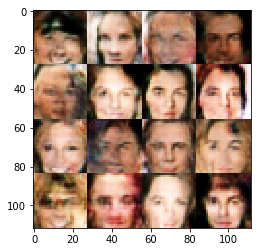

Epoch 1/1... Discriminator Loss: 0.9644... Generator Loss: 0.8790
Epoch 1/1... Discriminator Loss: 1.3344... Generator Loss: 0.9076
Epoch 1/1... Discriminator Loss: 1.4592... Generator Loss: 0.6508
Epoch 1/1... Discriminator Loss: 0.9217... Generator Loss: 1.3772
Epoch 1/1... Discriminator Loss: 1.0929... Generator Loss: 0.7059
Epoch 1/1... Discriminator Loss: 0.9926... Generator Loss: 1.8083
Epoch 1/1... Discriminator Loss: 1.1504... Generator Loss: 0.8078
Epoch 1/1... Discriminator Loss: 0.7052... Generator Loss: 1.0648
Epoch 1/1... Discriminator Loss: 1.1812... Generator Loss: 0.8112
Epoch 1/1... Discriminator Loss: 1.2141... Generator Loss: 0.6346


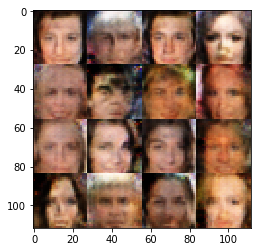

Epoch 1/1... Discriminator Loss: 1.8902... Generator Loss: 2.5585
Epoch 1/1... Discriminator Loss: 1.4996... Generator Loss: 0.4148
Epoch 1/1... Discriminator Loss: 1.0768... Generator Loss: 1.1248
Epoch 1/1... Discriminator Loss: 1.1419... Generator Loss: 0.5874
Epoch 1/1... Discriminator Loss: 1.0999... Generator Loss: 0.9513
Epoch 1/1... Discriminator Loss: 1.5929... Generator Loss: 1.8743
Epoch 1/1... Discriminator Loss: 1.1981... Generator Loss: 0.8493
Epoch 1/1... Discriminator Loss: 1.2101... Generator Loss: 0.9799
Epoch 1/1... Discriminator Loss: 0.9839... Generator Loss: 0.9741
Epoch 1/1... Discriminator Loss: 1.0886... Generator Loss: 0.6985


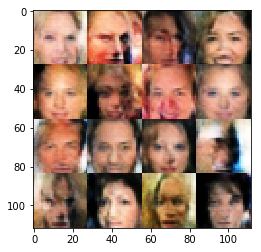

Epoch 1/1... Discriminator Loss: 0.9275... Generator Loss: 1.1777
Epoch 1/1... Discriminator Loss: 1.2619... Generator Loss: 0.6095
Epoch 1/1... Discriminator Loss: 0.9457... Generator Loss: 0.9036
Epoch 1/1... Discriminator Loss: 1.2524... Generator Loss: 0.7863
Epoch 1/1... Discriminator Loss: 0.9229... Generator Loss: 1.2815
Epoch 1/1... Discriminator Loss: 2.0245... Generator Loss: 0.1732
Epoch 1/1... Discriminator Loss: 1.2060... Generator Loss: 0.6325
Epoch 1/1... Discriminator Loss: 1.0944... Generator Loss: 0.7754
Epoch 1/1... Discriminator Loss: 1.0142... Generator Loss: 0.7786
Epoch 1/1... Discriminator Loss: 0.9445... Generator Loss: 0.8310


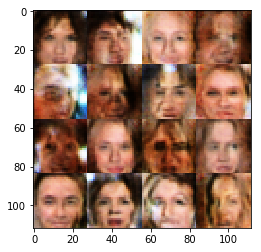

Epoch 1/1... Discriminator Loss: 1.0279... Generator Loss: 0.8017
Epoch 1/1... Discriminator Loss: 0.5833... Generator Loss: 1.4768
Epoch 1/1... Discriminator Loss: 1.7985... Generator Loss: 0.2242
Epoch 1/1... Discriminator Loss: 1.0753... Generator Loss: 0.8485
Epoch 1/1... Discriminator Loss: 1.2700... Generator Loss: 0.5584
Epoch 1/1... Discriminator Loss: 1.9689... Generator Loss: 2.4614
Epoch 1/1... Discriminator Loss: 1.1539... Generator Loss: 0.6200
Epoch 1/1... Discriminator Loss: 1.2568... Generator Loss: 0.8094
Epoch 1/1... Discriminator Loss: 0.4967... Generator Loss: 1.5119
Epoch 1/1... Discriminator Loss: 1.3361... Generator Loss: 0.4637


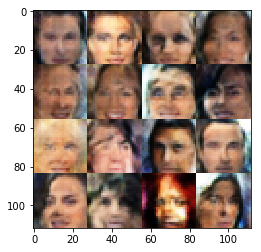

Epoch 1/1... Discriminator Loss: 1.1779... Generator Loss: 0.6024
Epoch 1/1... Discriminator Loss: 1.4746... Generator Loss: 1.1017
Epoch 1/1... Discriminator Loss: 1.4317... Generator Loss: 0.3407
Epoch 1/1... Discriminator Loss: 1.3236... Generator Loss: 0.7516
Epoch 1/1... Discriminator Loss: 0.5806... Generator Loss: 1.5415
Epoch 1/1... Discriminator Loss: 0.4605... Generator Loss: 1.6059
Epoch 1/1... Discriminator Loss: 1.3638... Generator Loss: 0.4203
Epoch 1/1... Discriminator Loss: 1.1713... Generator Loss: 0.8202
Epoch 1/1... Discriminator Loss: 1.2344... Generator Loss: 0.8961
Epoch 1/1... Discriminator Loss: 1.2121... Generator Loss: 0.6016


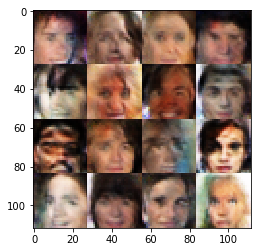

Epoch 1/1... Discriminator Loss: 1.2614... Generator Loss: 0.6944
Epoch 1/1... Discriminator Loss: 1.6576... Generator Loss: 0.3045
Epoch 1/1... Discriminator Loss: 0.6765... Generator Loss: 1.1993
Epoch 1/1... Discriminator Loss: 1.0447... Generator Loss: 0.6083
Epoch 1/1... Discriminator Loss: 1.1095... Generator Loss: 0.7911
Epoch 1/1... Discriminator Loss: 1.3848... Generator Loss: 0.5003
Epoch 1/1... Discriminator Loss: 1.1223... Generator Loss: 0.6860
Epoch 1/1... Discriminator Loss: 1.1690... Generator Loss: 0.8714
Epoch 1/1... Discriminator Loss: 1.1323... Generator Loss: 0.7376
Epoch 1/1... Discriminator Loss: 1.2900... Generator Loss: 0.5682


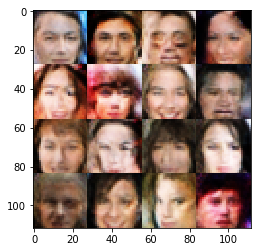

Epoch 1/1... Discriminator Loss: 1.3105... Generator Loss: 0.5922
Epoch 1/1... Discriminator Loss: 1.0706... Generator Loss: 0.7586
Epoch 1/1... Discriminator Loss: 1.2993... Generator Loss: 0.7537
Epoch 1/1... Discriminator Loss: 1.2678... Generator Loss: 0.5927
Epoch 1/1... Discriminator Loss: 1.1161... Generator Loss: 0.7606
Epoch 1/1... Discriminator Loss: 1.3645... Generator Loss: 0.8224


In [14]:
batch_size = 32
z_dim = 50
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.